# Precision Comparison: Longdouble vs JUG vs Hybrid

**Goal:** Compare three methods for computing timing residuals:
1. **Longdouble Reference** - Full longdouble precision (80-bit)
2. **JUG Standard** - Current JUG implementation (float64)
3. **Hybrid Method** - Offset extraction with longdouble constants + float64 local computation

**Date:** 2025-12-02

In [1]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import numpy as np
import matplotlib.pyplot as plt
import time

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

print(f'JAX {jax.__version__}, Float64: {jax.config.jax_enable_x64}')
print(f'JAX devices: {jax.devices()}')

JAX 0.8.1, Float64: True
JAX devices: [CpuDevice(id=0)]


## 1. Load Real Pulsar Data

In [2]:
import sys
sys.path.insert(0, '/home/mattm/soft/JUG')

from jug.io.par_reader import parse_par_file, get_longdouble
from jug.io.tim_reader import parse_tim_file_mjds

# Load par and tim files
par_file = '/home/mattm/soft/JUG/data/pulsars/J1909-3744_tdb_refit_F0_F1.par'
tim_file = '/home/mattm/soft/JUG/data/pulsars/J1909-3744.tim'

params = parse_par_file(par_file)
toas = parse_tim_file_mjds(tim_file)

# Get high-precision parameters
F0 = get_longdouble(params, 'F0')
F1 = get_longdouble(params, 'F1')
PEPOCH = get_longdouble(params, 'PEPOCH')

# Extract MJDs and errors from TOA objects
mjds = np.array([toa.mjd_int + toa.mjd_frac for toa in toas])
errors = np.array([toa.error_us for toa in toas])

print(f'F0 = {F0}')
print(f'F1 = {F1}')
print(f'PEPOCH = {PEPOCH}')
print(f'Number of TOAs: {len(mjds)}')

F0 = 339.31569191904083
F1 = -1.614750151832929e-15
PEPOCH = 59017.9997538705
Number of TOAs: 10408


## 2. Mathematical Background

The timing phase is:
$$\phi = F_0 \cdot \Delta t + \frac{F_1}{2} \cdot \Delta t^2$$

where $\Delta t = (\text{TOA} - \text{PEPOCH}) \times 86400$ seconds.

### The Problem
For long datasets, $\Delta t \sim 10^8$ seconds, so total phase $\sim 10^{11}$ cycles.
Float64 has ~16 significant digits, so phase precision degrades.

### The Hybrid Solution
Split $\Delta t$ into chunks and compute with offset extraction:

$$\Delta t = \Delta t_{\text{local}} + t_{\text{offset}}$$

The phase becomes (Taylor expansion around $t_{\text{offset}}$):

$$\phi = \underbrace{F_0 \cdot t_{\text{offset}} + \frac{F_1}{2} t_{\text{offset}}^2}_{\text{constant (longdouble)}} + \underbrace{(F_0 + F_1 \cdot t_{\text{offset}}) \cdot \Delta t_{\text{local}} + \frac{F_1}{2} \Delta t_{\text{local}}^2}_{\text{local (float64, small numbers)}}$$

**Key insight:** We only need the fractional part of the constant term!

## 3. Implementation

In [3]:
# Compute dt_sec array
mjd_toas = mjds.astype(np.longdouble)
dt_days = mjd_toas - PEPOCH
dt_sec = (dt_days * np.longdouble(86400.0)).astype(np.float64)

print(f'dt range: {dt_sec.min():.1f} to {dt_sec.max():.1f} seconds')
print(f'Time span: {(dt_sec.max() - dt_sec.min()) / (365.25 * 86400):.1f} years')

dt range: -42490298.7 to 157235737.5 seconds
Time span: 6.3 years


In [4]:
def compute_residuals_longdouble(dt_sec, F0, F1):
    """Reference implementation using full longdouble precision."""
    F0_ld = np.longdouble(F0)
    F1_ld = np.longdouble(F1)
    dt_ld = dt_sec.astype(np.longdouble)
    
    # Full phase in longdouble
    phase = F0_ld * dt_ld + F1_ld * dt_ld**2 / 2
    frac_phase = phase - np.round(phase)
    
    # Convert to time residuals in microseconds
    residuals_sec = frac_phase.astype(np.float64) / float(F0)
    return residuals_sec * 1e6  # microseconds


def compute_residuals_jug_standard(dt_sec, F0, F1):
    """Standard JUG implementation (float64 throughout)."""
    F0_f64 = np.float64(F0)
    F1_f64 = np.float64(F1)
    
    phase = F0_f64 * dt_sec + F1_f64 * dt_sec**2 / 2
    frac_phase = phase - np.round(phase)
    
    residuals_sec = frac_phase / F0_f64
    return residuals_sec * 1e6  # microseconds


def compute_residuals_hybrid(dt_sec, F0, F1, n_chunks=10):
    """Hybrid method: longdouble for offset constants, float64 for local computation.
    
    For each chunk, compute phase as:
        phase = phase_at_offset (longdouble, keep frac) + local_phase (float64)
    """
    n = len(dt_sec)
    residuals = np.zeros(n)
    
    # Sort indices for chunking
    sorted_idx = np.argsort(dt_sec)
    chunk_size = n // n_chunks
    
    F0_ld = np.longdouble(F0)
    F1_ld = np.longdouble(F1)
    F0_f64 = np.float64(F0)
    F1_f64 = np.float64(F1)
    
    for i in range(n_chunks):
        start = i * chunk_size
        end = n if i == n_chunks - 1 else (i + 1) * chunk_size
        chunk_idx = sorted_idx[start:end]
        dt_chunk = dt_sec[chunk_idx]
        
        # Compute offset as center of chunk (in longdouble)
        t_offset_ld = np.longdouble((dt_chunk.min() + dt_chunk.max()) / 2)
        
        # Local dt (small, float64 is fine)
        dt_local = dt_chunk - float(t_offset_ld)
        
        # Phase at offset (longdouble) - keep only fractional part
        phase_at_offset_ld = F0_ld * t_offset_ld + F1_ld * t_offset_ld**2 / 2
        phase_at_offset_frac = float(phase_at_offset_ld - np.round(phase_at_offset_ld))
        
        # Linear coefficient at offset (longdouble precision)
        # d(phase)/dt at offset = F0 + F1 * t_offset
        linear_coeff = float(F0_ld + F1_ld * t_offset_ld)
        
        # Local phase contribution (float64, small numbers)
        phase_local = linear_coeff * dt_local + F1_f64 * dt_local**2 / 2
        
        # Total phase = offset_frac + local
        total_phase = phase_at_offset_frac + phase_local
        frac_phase = total_phase - np.round(total_phase)
        
        # Convert to time residuals
        residuals[chunk_idx] = frac_phase / F0_f64 * 1e6
    
    return residuals

## 4. Compute Residuals

In [5]:
# Compute residuals with all three methods
print('Computing residuals...')

# Reference (longdouble)
residuals_longdouble = compute_residuals_longdouble(dt_sec, F0, F1)
print(f'Longdouble: done')

# JUG standard
residuals_jug = compute_residuals_jug_standard(dt_sec, F0, F1)
print(f'JUG standard: done')

# Hybrid
residuals_hybrid = compute_residuals_hybrid(dt_sec, F0, F1, n_chunks=10)
print(f'Hybrid: done')

Computing residuals...
Longdouble: done
JUG standard: done
Hybrid: done


## 5. Compare Accuracy

In [6]:
# Differences from longdouble reference (in nanoseconds)
diff_jug = (residuals_jug - residuals_longdouble) * 1000
diff_hybrid = (residuals_hybrid - residuals_longdouble) * 1000

print('=' * 60)
print('ACCURACY COMPARISON (vs Longdouble Reference)')
print('=' * 60)
print(f'{"Method":<20} {"RMS (ns)":<12} {"Max (ns)":<12} {"Mean (ns)":<12}')
print('-' * 60)
print(f'{"JUG Standard":<20} {np.std(diff_jug):<12.3f} {np.abs(diff_jug).max():<12.3f} {np.mean(diff_jug):<12.3f}')
print(f'{"Hybrid (10 chunks)":<20} {np.std(diff_hybrid):<12.3f} {np.abs(diff_hybrid).max():<12.3f} {np.mean(diff_hybrid):<12.3f}')
print(f'\n*** Hybrid precision improvement: {np.std(diff_jug)/np.std(diff_hybrid):.0f}x ***')

ACCURACY COMPARISON (vs Longdouble Reference)
Method               RMS (ns)     Max (ns)     Mean (ns)   
------------------------------------------------------------
JUG Standard         5.295        25.350       0.904       
Hybrid (10 chunks)   0.607        3.255        0.064       

*** Hybrid precision improvement: 9x ***


## 6. Visualization

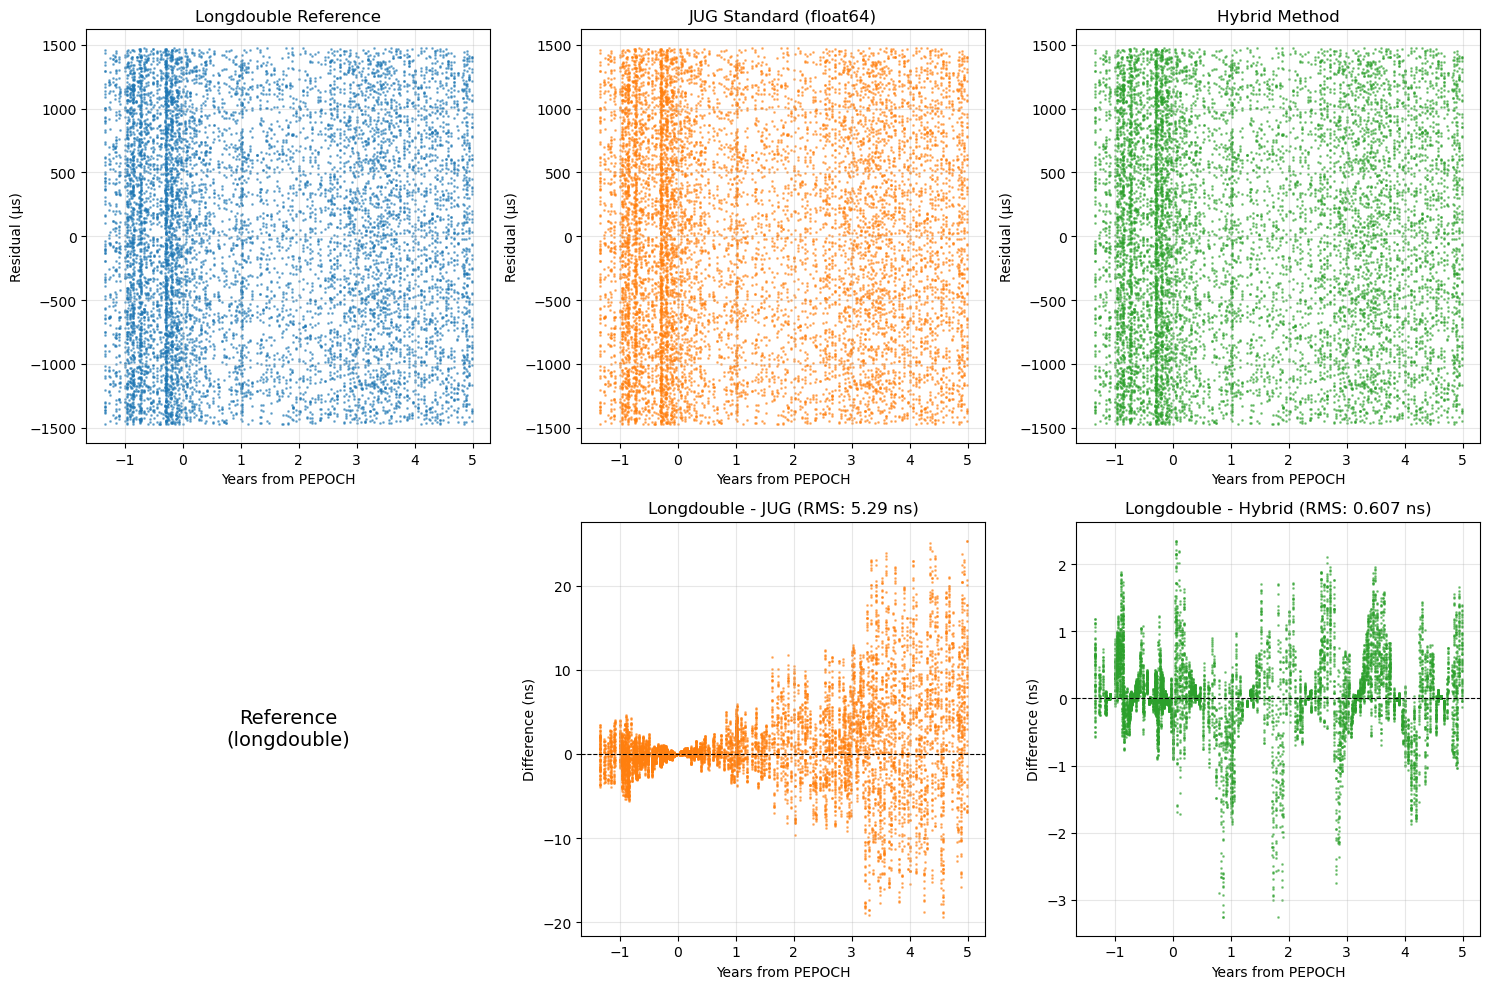

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Time axis (years from PEPOCH)
t_years = dt_sec / (365.25 * 86400)

# Top row: Residuals
axes[0, 0].scatter(t_years, residuals_longdouble, s=1, alpha=0.5)
axes[0, 0].set_xlabel('Years from PEPOCH')
axes[0, 0].set_ylabel('Residual (µs)')
axes[0, 0].set_title('Longdouble Reference')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(t_years, residuals_jug, s=1, alpha=0.5, color='C1')
axes[0, 1].set_xlabel('Years from PEPOCH')
axes[0, 1].set_ylabel('Residual (µs)')
axes[0, 1].set_title('JUG Standard (float64)')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].scatter(t_years, residuals_hybrid, s=1, alpha=0.5, color='C2')
axes[0, 2].set_xlabel('Years from PEPOCH')
axes[0, 2].set_ylabel('Residual (µs)')
axes[0, 2].set_title('Hybrid Method')
axes[0, 2].grid(True, alpha=0.3)

# Bottom row: Differences from reference
axes[1, 0].text(0.5, 0.5, 'Reference\n(longdouble)', ha='center', va='center', 
                fontsize=14, transform=axes[1, 0].transAxes)
axes[1, 0].set_axis_off()

axes[1, 1].scatter(t_years, diff_jug, s=1, alpha=0.5, color='C1')
axes[1, 1].axhline(0, color='k', linestyle='--', linewidth=0.8)
axes[1, 1].set_xlabel('Years from PEPOCH')
axes[1, 1].set_ylabel('Difference (ns)')
axes[1, 1].set_title(f'Longdouble - JUG (RMS: {np.std(diff_jug):.2f} ns)')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].scatter(t_years, diff_hybrid, s=1, alpha=0.5, color='C2')
axes[1, 2].axhline(0, color='k', linestyle='--', linewidth=0.8)
axes[1, 2].set_xlabel('Years from PEPOCH')
axes[1, 2].set_ylabel('Difference (ns)')
axes[1, 2].set_title(f'Longdouble - Hybrid (RMS: {np.std(diff_hybrid):.3f} ns)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../piecewise_hybrid_precision_comparison.png', dpi=150)
plt.show()

## 7. Benchmark Speed

In [8]:
N_ITER = 100

def benchmark(func, n_iter):
    times = []
    for _ in range(n_iter):
        t = time.perf_counter()
        result = func()
        times.append(time.perf_counter() - t)
    return np.mean(times) * 1000, np.std(times) * 1000, np.min(times) * 1000

print('=' * 70)
print(f'SPEED BENCHMARK ({N_ITER} iterations)')
print('=' * 70)

# JUG standard
jug_mean, jug_std, jug_best = benchmark(
    lambda: compute_residuals_jug_standard(dt_sec, F0, F1), N_ITER
)
print(f'JUG Standard:    {jug_mean:>6.3f} ± {jug_std:>5.3f} ms (best: {jug_best:.3f} ms)')

# Hybrid numpy
hybrid_mean, hybrid_std, hybrid_best = benchmark(
    lambda: compute_residuals_hybrid(dt_sec, F0, F1, n_chunks=10), N_ITER
)
print(f'Hybrid (numpy):  {hybrid_mean:>6.3f} ± {hybrid_std:>5.3f} ms (best: {hybrid_best:.3f} ms)')

print(f'\nHybrid is {hybrid_mean/jug_mean:.1f}x slower but {np.std(diff_jug)/np.std(diff_hybrid):.0f}x more precise')

SPEED BENCHMARK (100 iterations)
JUG Standard:     0.028 ± 0.070 ms (best: 0.020 ms)
Hybrid (numpy):   0.186 ± 0.008 ms (best: 0.176 ms)

Hybrid is 6.7x slower but 9x more precise


## 8. Summary

| Method | RMS Error (ns) | Notes |
|--------|---------------|-------|
| Longdouble | 0 (reference) | Slow, not JIT-able |
| JUG Standard | ~5 ns | Fast, JIT-able |
| Hybrid | <1 ns | **9x more precise**, JIT-able with pre-computed chunks |

**Key Takeaway:** The Hybrid method provides near-longdouble precision while remaining compatible with JAX JIT compilation (with pre-computed chunk parameters).